In [17]:
import jax.numpy as jnp
from jax import jit,grad,hessian,jacfwd,jacrev
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *

from scipy.integrate import solve_ivp
from jax.scipy.linalg import block_diag

from jax.scipy.linalg import solve

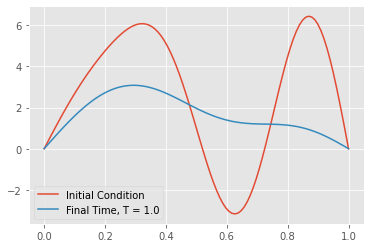

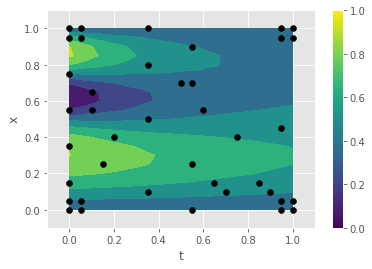

In [67]:
fourier_coefficients = jnp.array([3.,2.,3,-3.,1.])
frequencies = jnp.arange(1,len(fourier_coefficients)+1)* jnp.pi
kappa = 0.02
def f_single(x):
    return jnp.sum(fourier_coefficients * jnp.sin(frequencies * x))

f = jax.vmap(f_single)

def u_single(tx):
    t = tx[0]
    x = tx[1]
    new_coefficients = jnp.exp(-frequencies**2 * t * kappa) * fourier_coefficients
    return jnp.sum(new_coefficients * jnp.sin(frequencies * x))
u_true_function = jax.vmap(u_single)

gridsize = 100
grid = np.linspace(0,1,gridsize)
final_time = 1.
tx_input = jnp.vstack([jnp.ones(gridsize)*final_time,grid]).T

plt.plot(grid,f(grid),label = "Initial Condition")
plt.plot(grid,u_true_function(tx_input),label = f"Final Time, T = {final_time}")
plt.legend()
plt.show()

num_grid_points = 21
t,x = np.meshgrid(np.linspace(0,final_time,num_grid_points),np.linspace(0,1,num_grid_points))
tx_grid = np.vstack([t.flatten(),x.flatten()]).T
u_true = u_true_function(tx_grid)

num_obs = 40
np.random.seed(21)

#Explicitly push some extra samples at initial conditions and at corners
init_obs_inds = jnp.where(tx_grid[:,0]==0)[0][3:-3:4]
num_init_obs_inds = len(init_obs_inds)

corner_inds = np.where(
    (jnp.min(jnp.abs(tx_grid[:,0]- jnp.array([0,0.05,0.95,1]).reshape(-1,1)),axis=0)<1e-6)
    &(jnp.min(jnp.abs(tx_grid[:,1]- jnp.array([0,0.05,0.95,1]).reshape(-1,1)),axis=0)<1e-6)
)[0]
num_corner_obs = len(corner_inds)

remaining_inds = (
    set(list(np.arange(len(tx_grid)))) - 
    set(list(np.where(tx_grid[:,0]==0)[0])) - 
    set(list(corner_inds))
)

num_obs_to_sample = num_obs - num_init_obs_inds - num_corner_obs
x_t_sample_inds = np.random.choice(list(remaining_inds),num_obs_to_sample,replace = False)
obs_inds = np.hstack([init_obs_inds,corner_inds,x_t_sample_inds])


tx_obs = tx_grid[obs_inds]

u_obs = u_true[obs_inds]


plt.tricontourf(tx_grid[:,0],tx_grid[:,1],u_true)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black')
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)

plt.show()

k_u = get_gaussianRBF(0.1)


In [47]:
u_operators = [eval_k,dx_k,dt_k]
feature_operators = [eval_k,dx_k,dxx_k]
k_u = get_gaussianRBF(0.1)

u_model = InducedRKHS(
    tx_grid,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_grid,u_params_init))
    .reshape(
            len(tx_grid),
            len(feature_operators),
            order = 'F'
        )
)

k_P = get_centered_scaled_poly_kernel(2,grid_features_init,c=1)
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params

class EqnModel():
    datafit_weight = 10

    @jit
    def get_grid_features(u_params):
        evaluation = u_model.evaluate_operators(feature_operators,tx_grid,u_params)
        grid_features = evaluation.reshape(len(tx_grid),len(feature_operators),order = 'F')
        return grid_features
    
    @jit
    def get_grid_target(u_params):
        return u_model.evaluate_operators([dt_k],tx_grid,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model.point_evaluate(tx_obs,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = EqnModel.eval_obs_points(u_params)
        return u_obs - obs_preds
    
    @jit
    def equation_residual(full_params):
        u_params = full_params[:u_model.num_params]
        P_params = full_params[u_model.num_params:]
        P_features = EqnModel.get_grid_features(u_params)
        P_model_preds = P_model.predict(P_features,P_params)
        ugrid_target = EqnModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(full_params):
        u_params = full_params[:u_model.num_params]
        eqn_res = EqnModel.equation_residual(full_params)
        data_res = EqnModel.datafit_residual(u_params)
        return jnp.hstack([
            EqnModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(full_params):
        return jnp.linalg.norm(EqnModel.F(full_params))**2
    
    @jit
    def damping_matrix(full_params):
        u_params = full_params[:u_model.num_params]
        grid_feats = EqnModel.get_grid_features(u_params)
        kmat_P = P_model.kernel_function(grid_feats,grid_feats)
        dmat = block_diag(
            u_model.kmat+1e-3 * diagpart(u_model.kmat),
            1e-3 * (kmat_P+1e-1 * jnp.identity(len(kmat_P)))
        )
        return dmat

In [46]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
params_init = jnp.hstack([u_params_init,jnp.zeros(len(tx_grid))])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-9,
    max_iter = 501,
    init_alpha=1,
    line_search_increase_ratio=3.
    
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 4.11, Jres = 390.2, alpha = 0.9091
Iteration 1, loss = 3.248, Jres = 151.3, alpha = 0.8264
Iteration 2, loss = 2.729, Jres = 68.5, alpha = 0.7513
Iteration 3, loss = 2.341, Jres = 50.38, alpha = 0.683
Iteration 4, loss = 2.032, Jres = 37.87, alpha = 0.6209
Iteration 5, loss = 1.78, Jres = 30.5, alpha = 0.5645
Iteration 50, loss = 0.1413, Jres = 0.3113, alpha = 0.007744
Iteration 100, loss = 0.006502, Jres = 0.2363, alpha = 6.597e-05
Iteration 150, loss = 0.0008543, Jres = 0.6388, alpha = 2.582e-06
Line Search Failed!!
Final Iteration Results
Iteration 182, loss = 0.0006174, Jres = 0.007731, alpha = 1.93e+04


In [24]:
hess_loss = jit(jax.hessian(EqnModel.loss))
gradloss = jit(jax.grad(EqnModel.loss))

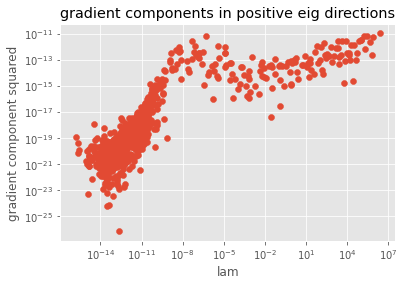

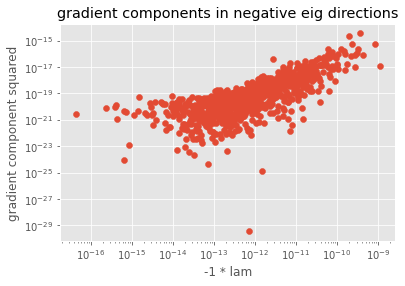

Most negative eigenvalue  -1.1150768341753048e-09


In [25]:
H = hess_loss(params)
g = gradloss(params)

H_vals,H_vecs = jnp.linalg.eigh(H)

g_H = H_vecs.T@g
gh_energy = g_H**2

plt.title("gradient components in positive eig directions")
plt.scatter(H_vals[H_vals>0],gh_energy[H_vals>0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("lam")
plt.ylabel("gradient component squared")

plt.show()

plt.title("gradient components in negative eig directions")
plt.scatter(-1 * H_vals[H_vals<0],gh_energy[H_vals<0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("-1 * lam")
plt.ylabel("gradient component squared")
plt.show()

print("Most negative eigenvalue ",jnp.min(H_vals))

In [26]:
def lsqL2(A, y, lamb=1e-10):
    U,S,Vt = np.linalg.svd(A, full_matrices=False)
    return Vt.T@((U.T@y)*(S/(S**2+lamb)))

def refine_sol(p_adjusted,lamb):
    J = EqnModel.jac(p_adjusted)
    rhs = EqnModel.F(p_adjusted)
    return p_adjusted - lsqL2(J,rhs,lamb)

p_adjusted = params.copy()
for i in range(3):
    p_adjusted = refine_sol(p_adjusted,1e-7)
print(EqnModel.loss(p_adjusted))
for i in range(3):
    p_adjusted = refine_sol(p_adjusted,1e-9)
print(EqnModel.loss(p_adjusted))
for i in range(3):
    p_adjusted = refine_sol(p_adjusted,1e-10)
print(EqnModel.loss(p_adjusted))
for i in range(6):
    p_adjusted = refine_sol(p_adjusted,1e-11)
print(EqnModel.loss(p_adjusted))

for i in range(3):
    p_adjusted = refine_sol(p_adjusted,1e-3)
print(EqnModel.loss(p_adjusted))

for i in range(3):
    p_adjusted = refine_sol(p_adjusted,1e-8)
print(EqnModel.loss(p_adjusted))

0.0005133789791500558
0.00011194725022606225
3.490220749924959e-05
8.99381180988267e-06
8.993811758961855e-06
8.992074782871147e-06


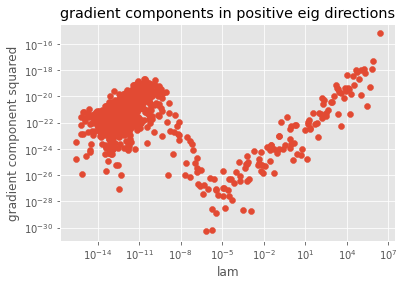

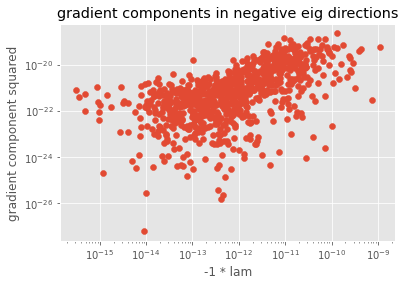

Most negative eigenvalue  -1.1072100825279474e-09


In [29]:
H = hess_loss(p_adjusted)
g = gradloss(p_adjusted)

H_vals,H_vecs = jnp.linalg.eigh(H)

g_H = H_vecs.T@g
gh_energy = g_H**2

plt.title("gradient components in positive eig directions")
plt.scatter(H_vals[H_vals>0],gh_energy[H_vals>0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("lam")
plt.ylabel("gradient component squared")

plt.show()

plt.title("gradient components in negative eig directions")
plt.scatter(-1 * H_vals[H_vals<0],gh_energy[H_vals<0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("-1 * lam")
plt.ylabel("gradient component squared")
plt.show()

print("Most negative eigenvalue ",jnp.min(H_vals))

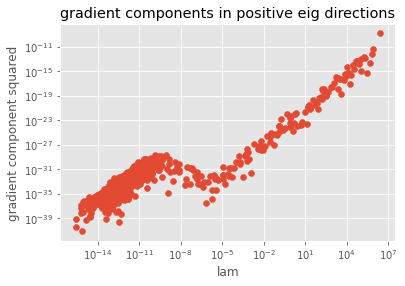

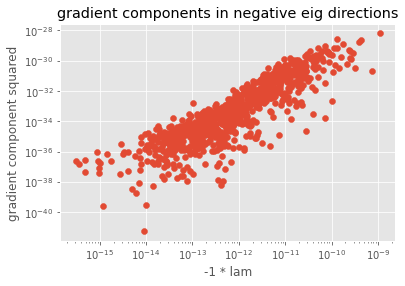

Most negative eigenvalue  -1.1072100825279474e-09


In [31]:
plt.title("gradient components in positive eig directions")
keep_inds = H_vals>0
plt.scatter(H_vals[keep_inds],H_vals[keep_inds] * gh_energy[keep_inds])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("lam")
plt.ylabel("gradient component squared")

plt.show()

plt.title("gradient components in negative eig directions")
keep_inds = H_vals<0
plt.scatter(-1 * H_vals[keep_inds],-1 * H_vals[keep_inds] * gh_energy[keep_inds])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("-1 * lam")
plt.ylabel("gradient component squared")
plt.show()

print("Most negative eigenvalue ",jnp.min(H_vals))

In [32]:
# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]


u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

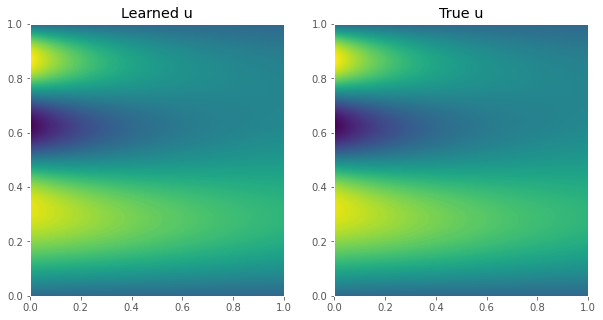

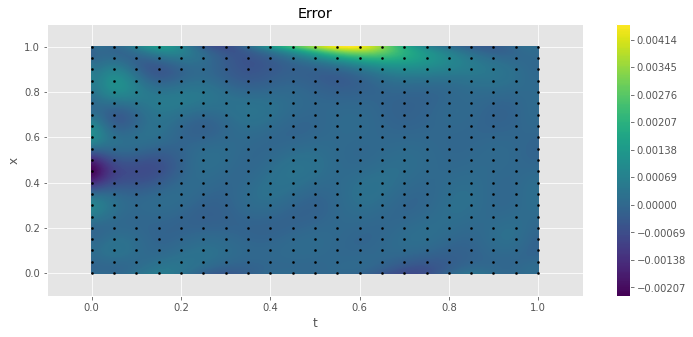

In [63]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.subplot(1,2,2)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_grid[:,0],tx_grid[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [34]:
grad_u_true = jax.vmap(grad(u_single))(tx_grid)
hess_u_true = jax.vmap(hessian(u_single))(tx_grid)

ut_true = grad_u_true[:,0]
ux_true = grad_u_true[:,1]
uxx_true = hess_u_true[:,1,1]

true_features = jnp.vstack([u_true,ux_true,uxx_true]).T
model_features = EqnModel.get_grid_features(u_sol)

preds_ut_model_features = P_model.predict(model_features,P_sol)
preds_ut_true_features = P_model.predict(true_features,P_sol)

In [35]:
init_P_features = EqnModel.get_grid_features(u_params_init)

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_grid_target(u_params_init))
P_preds_init_model_features_init = P_model.kernel_function(init_P_features,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

In [36]:
def get_nrmse(true,pred):
    return jnp.mean((true-pred)**2)/jnp.mean(true**2)

In [37]:
print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("Naive model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("Naive true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("Naive init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

Optimized model feature predictions  1.5776674883927054e-06
Optimized true feature predictions  0.0002198984403055602
Naive model feature predictions  0.17445426052957003
Naive true feature predictions  0.17444151732481142
Naive init model feature predictions  0.15526451004603614


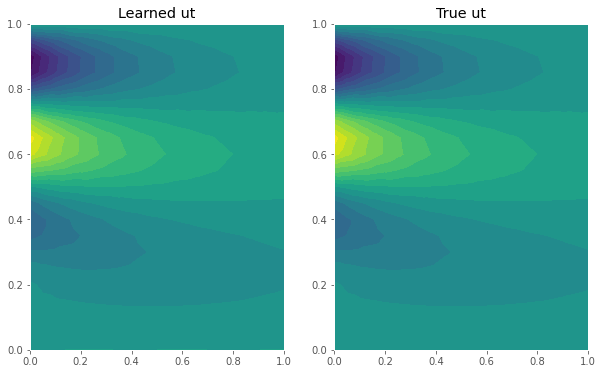

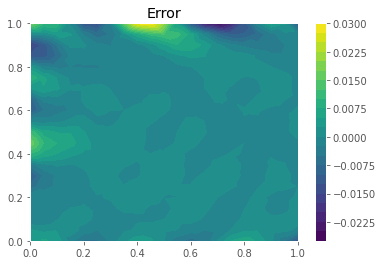

In [38]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Learned ut")
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],preds_ut_model_features,25)
plt.subplot(1,2,2)
plt.title("True ut")
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],ut_true,25)
plt.show()
plt.title("Error")
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],ut_true-preds_ut_model_features,25)
plt.colorbar()
plt.show()

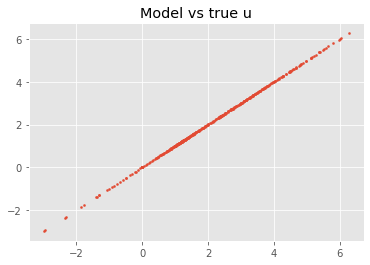

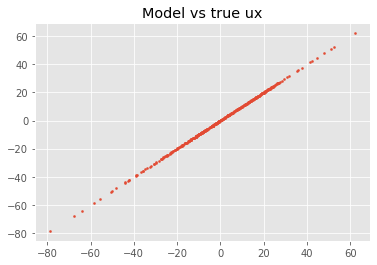

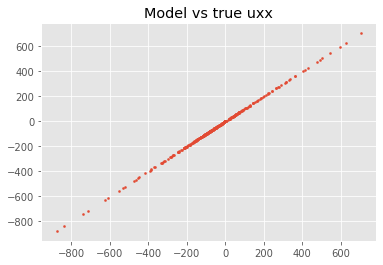

In [43]:
plt.title("Model vs true u")
plt.scatter(model_features[:,0],true_features[:,0],s = 4)
plt.show()

plt.title("Model vs true ux")
plt.scatter(model_features[:,1],true_features[:,1],s = 4)
plt.show()


plt.title("Model vs true uxx")
plt.scatter(model_features[:,2],true_features[:,2],s = 4)
plt.show()

In [44]:
wrong_inds = jnp.where(jnp.abs(model_features[:,2]-true_features[:,2])>=1)

(-0.1, 1.1)

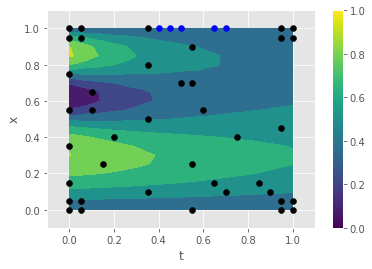

In [45]:
plt.tricontourf(tx_grid[:,0],tx_grid[:,1],u_true)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black')
plt.scatter(tx_grid[wrong_inds][:,0],tx_grid[wrong_inds][:,1],c='blue')
plt.colorbar()
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)


